# **PROJETO FINAL: CREDIT SCORING**
---
---
---



## **1.Introdução**

### 1.1.Objetivo

Esse notebook trata-se do projeto final de conclusão do curso Profissão: Cientista de Dados da **Escola Britânica de Artes Criativas & Tecnologia (EBAC)**.

O objetivo aqui é demonstar nossas habilidades adquiridas ao longo do curso, sendo as principais que iremos abordar aqui:
* Tratamento de Dados
* Agrupamento
* Visualização
* Aprendizado de Máquina
* Inferência Estatística
* Análise de Dados
* Deploying



### 1.2.Tarefas

O que iremos fazer é trabalhar com um dataset de credit scoring, onde iremos:
* Realizar todos os tratamentos necessários para realizar uma regressão logística;
* Fazer inferência estatística sobre as variáveis e analisar os resultados obtidos pelo o modelo, de tal forma que possamos ter o melhor modelo possível;
* Desenvolver um aplicação via **streamlit** que possa receber um novo dataset de mesma estrutura, simulando a inserção de novos dados.
* A partir desses novos dados, realizar uma pipeline que faça o tratamento de dados, e preditize o resultado a partir daquele nosso modelo encontrado, e disponibilize-o por download.

### 1.3.Dataset

É uma base fictícia de agência de crédito, que tem informações sobre seus clientes, sendo a mais importante, e sendo ela a nossa variável target, se o cliente é ou não é inadimplente.

Essas são as nossas variáveis:



|**Nome**|**Referência**|**Tipo**|**Descrição**|
|-|-|-|-|
|Data|data_ref|datetime|Data da instância.|
|Sexo|sexo|string|Sexo do cliente. (F ou M)|
|Posse de Veículo|posse_de_veiculo|string|Se o cliente possui, ou não, veículo. (S ou N)|
|Posse de Imóvel|posse_de_imovel|string|Se o cliente possui, ou não, imóvel. (S ou N)|
|Quantidade de Filhos|qtd_filhos|inteiro|Quantidade de filhos do cliente.|
|Tipo de Renda|tipo_renda|string|Categoria da renda do cliente.|
|Educação|educacao|string|Nível escolar do cliente.|
|Estado Civíl|estado_civil|string|Estado civíl do cliente.|
|Resiência|tipo_residência|string|Tipo de residência do cliente.|
|Idade|idade|inteiro|Idade do cliente.|
|Tempo de Emprego|tempo_emprego|decimal|Tempo de trabalho no atual emprego do cliente.|
|Quantidade de Pessoas na Residência|qt_pessoas_residencia|inteiro|Quantidade de residentes do cliente.|
|Renda|renda|decimal|Tempo de trabalho no atual emprego do cliente.|
|Target|mau|booleano|Se o cliente é ou não um mal cliente.|






#### 1.3.1.Características

* **Quantidade de Linhas:** 750000
* **Colunas:** 14
* **Data Mínima:** 01/01/2015
* **Data Máxima:** 01/03/2016

## **2.Importando Bibliotecas**

* **Pandas:** Biblioteca para operação com dados estruturados, como series e dataframes.
* **Numpy:** Biblioteca matemática avançada do Python, muito utilizada para operações com vetores.
* **MatPlotLib:** Biblioteca de visualização de gráficos.
* **SeaBorn:** Biblioteca de visualização de gráficos.
* **SKLearn:** Biblioteca para aprendizado de máquina.
* **StatsModels:** Biblioteca para análise estatística, modelagem econométrica e teste de hipóteses, com suporte a estimativas e gráficos avançados.
* **Patsy:** Biblioteca para criar e manipular modelos estatísticos usando fórmulas do tipo R.
* **Scipy:** Biblioteca para computação científica, focada em álgebra linear, otimização, integração e estatísticas.
* **PyCaret:** Biblioteca Python de automação de aprendizado de máquina que simplifica a construção, comparação e implementação de modelos preditivos.
* **Pickle:** Formato de leitura de arquivo.

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_curve, classification_report, confusion_matrix,recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector


import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import statsmodels.api as sm
from scipy.stats import ks_2samp
from scipy.stats import t
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from scipy.interpolate import interp1d

from scipy.stats import shapiro, normaltest
from statsmodels.graphics.gofplots import qqplot

from pycaret.classification import *
from pycaret.classification import load_model

import pickle

## **3.Análise dos Dados**

### 3.0.Amostragem

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Portanto, como se trata de um problema de série temportal, iremos realizar uma sampling out of time, separando os últimos 3 meses para teste.

In [46]:
#retirando a coluna de index e ordenando pela o dataframe pela a data
df = pd.read_feather('credit_scoring.ftr').drop(columns='index').sort_values('data_ref').rename(columns={'data_ref':'data'})
df.head()

,data,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
33328,2015-01-01,M,S,S,1,Assalariado,Médio,Casado,Casa,41,8.134247,3.0,4979.48,False
33329,2015-01-01,F,N,N,0,Assalariado,Superior completo,Solteiro,Casa,26,1.424658,1.0,1285.25,False
33330,2015-01-01,M,N,S,1,Assalariado,Superior incompleto,Casado,Casa,37,15.449315,3.0,14473.15,False
33331,2015-01-01,F,N,S,1,Assalariado,Médio,Casado,Casa,30,0.369863,3.0,1366.63,False


In [47]:
data_corte = df['data'].max() - pd.DateOffset(months=3)

In [48]:
#Dividindo a base em treino e teste
df_treino = df[df['data'] < data_corte]
df_teste = df[df['data'] >= data_corte]

### 3.1.Descritiva Básica Univariada

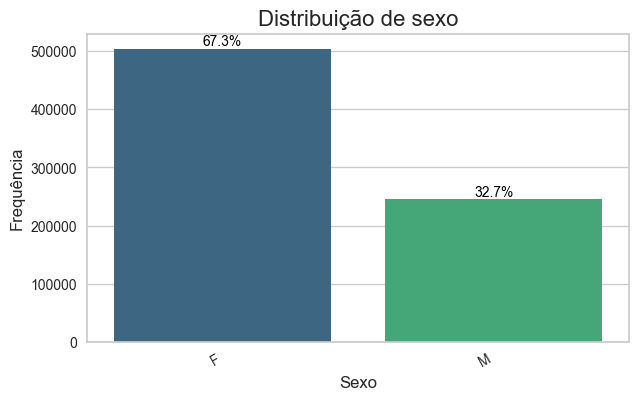

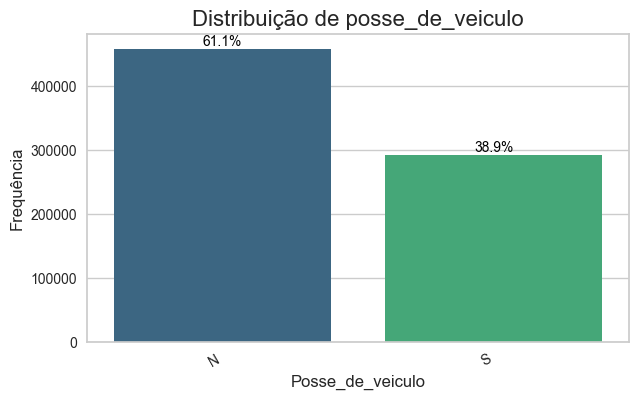

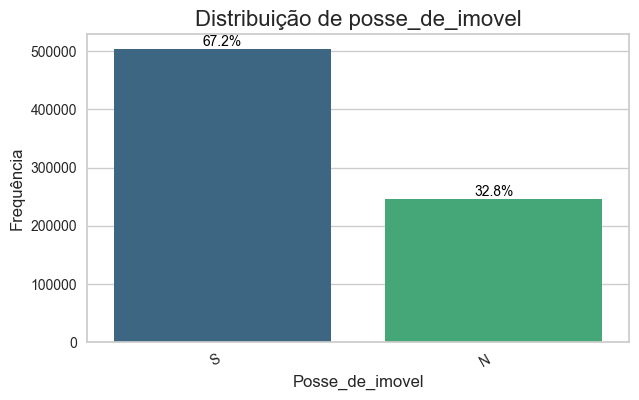

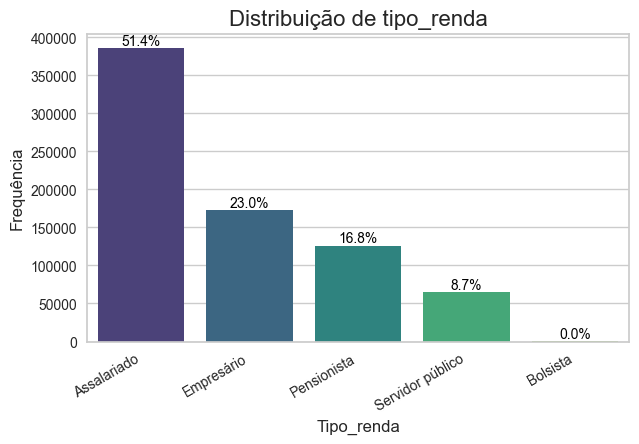

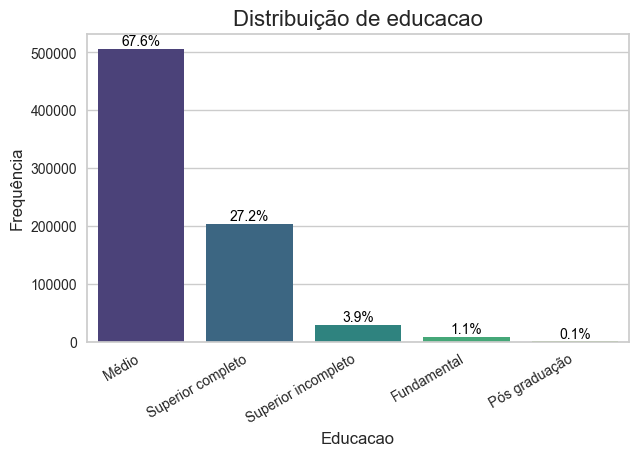

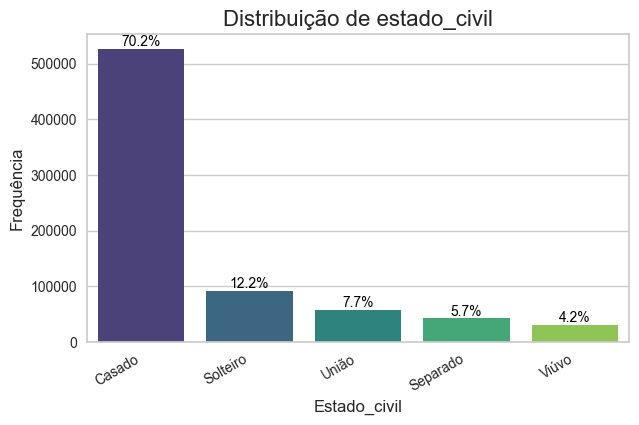

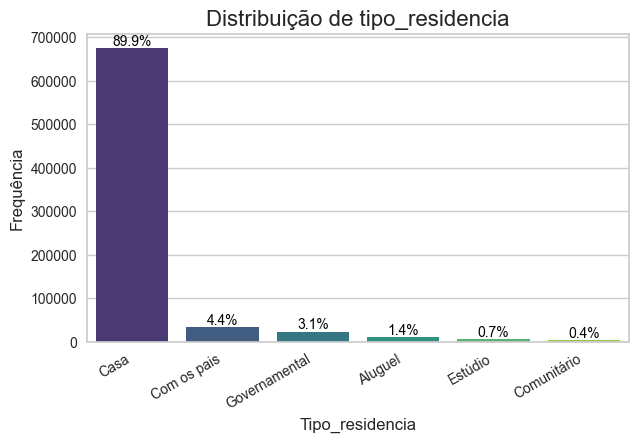

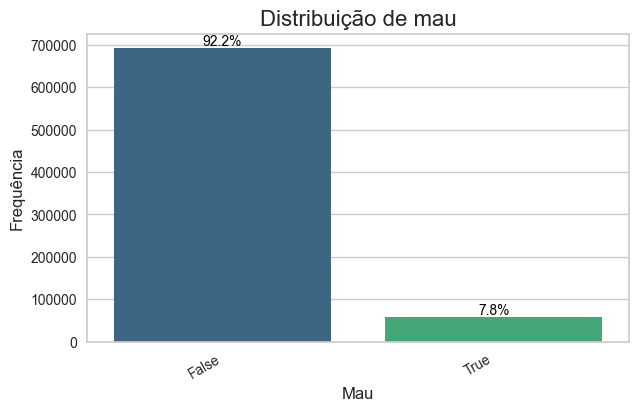

In [49]:
#Análise das variáveis categóricas
categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda',
               'educacao', 'estado_civil', 'tipo_residencia', 'mau']

for col in categoricas:
    plt.figure(figsize=(7, 4))
    ax = sns.countplot(data=df, x=col, palette="viridis", order=df[col].value_counts().index)

    total = len(df[col])
    for p in ax.patches:
        percentage = f"{100 * p.get_height() / total:.1f}%"
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10, color='black')

    plt.title(f"Distribuição de {col}", fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel("Frequência", fontsize=12)
    plt.xticks(rotation=30, ha='right')
    plt.show()

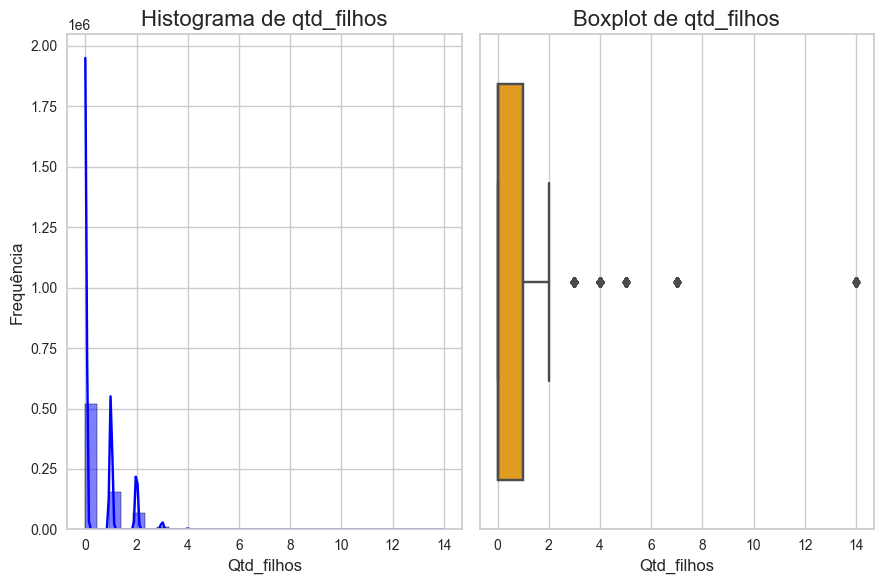

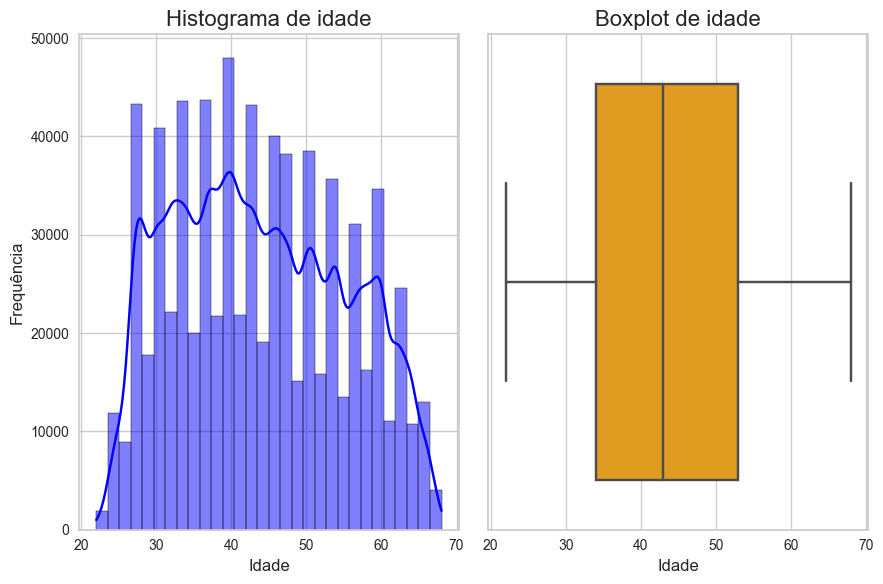

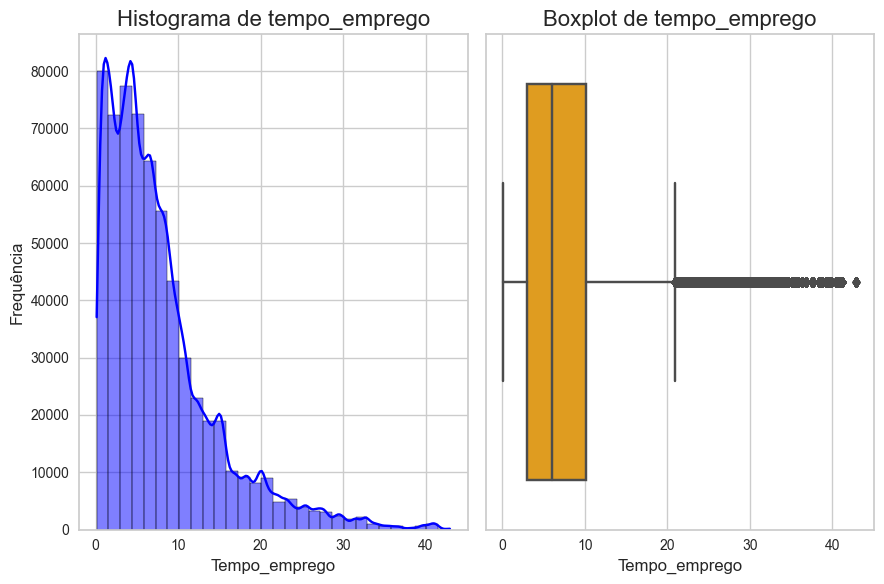

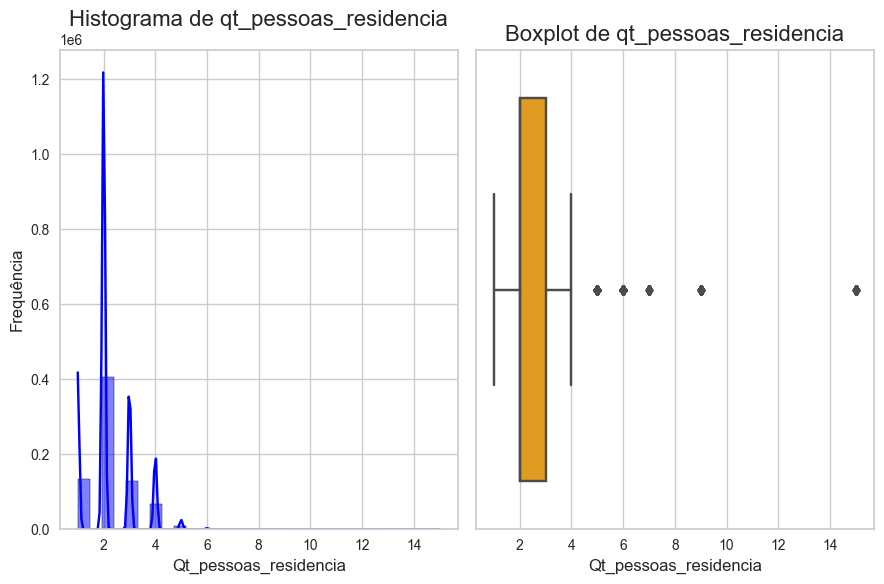

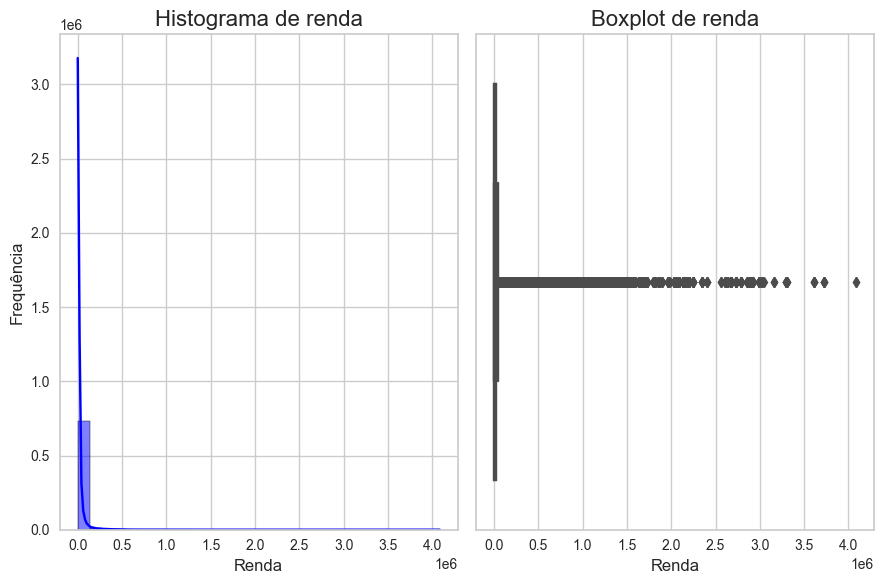

In [50]:
#Análise das Variáveis Numéricas
numericas = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

for col in numericas:
    plt.figure(figsize=(9, 6))

    # Histograma com KDE (curva de densidade)
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=col, kde=True, color="blue", bins=30)
    plt.title(f"Histograma de {col}", fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel("Frequência", fontsize=12)

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x=col, color="orange")
    plt.title(f"Boxplot de {col}", fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=12)

    plt.tight_layout()
    plt.show()

Conclusões rápidas:
* É uma base que 2/3 dela são mulheres.
* É uma base que sua grande maioria são casados, assalariados, e moram em casa própria.
* É também uma base, pouco especializada academicamente, apenas 28% possuem uma graduação.
* É uma base que tem uma quantidade de pessoas que ganham muito bem considerável.
* A maior parte são formado por jovem adultos e adultos (entre 30-59 anos).
* É uma base desbalanceada, apenas 7,8% dela são inadimplentes. Portanto, para o modelo, acurácia não deve ser um score interessante.

### 3.2.Descritiva Bivariada

Vamos fazer uma análise de cada variável em relação a nossa variável target.

In [51]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    ax[1] = biv.cont.plot.bar()
    return biv

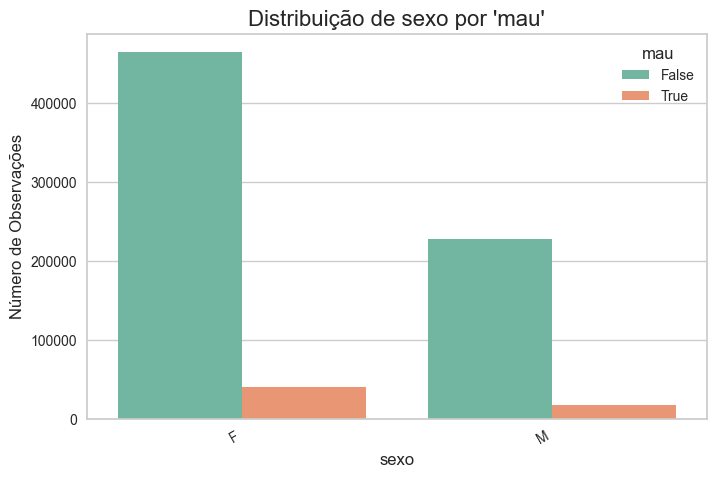

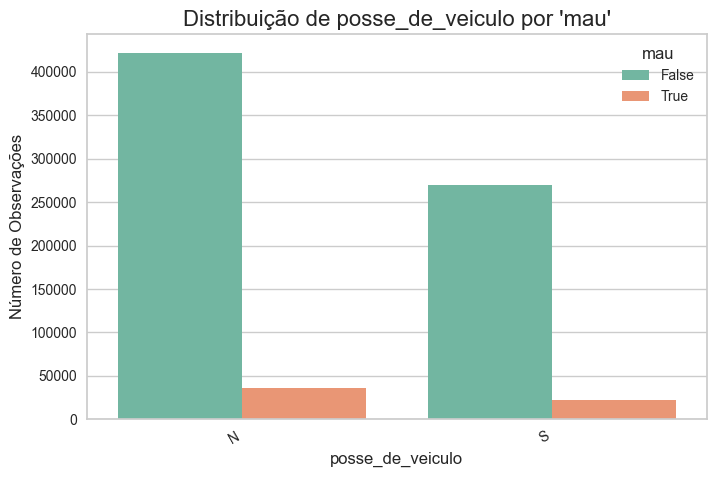

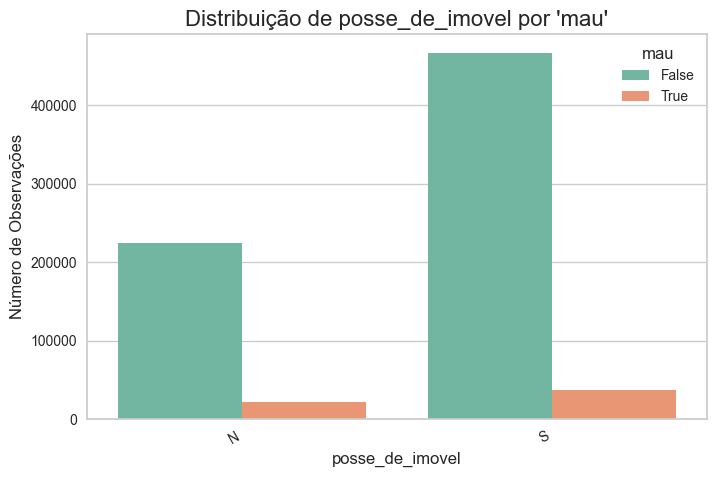

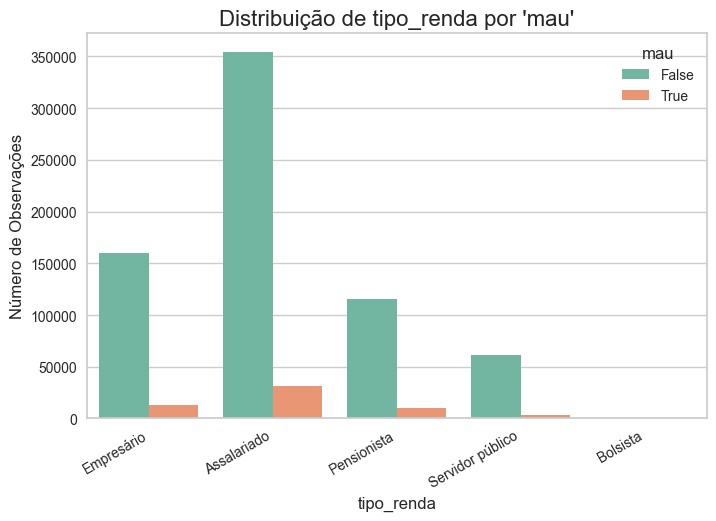

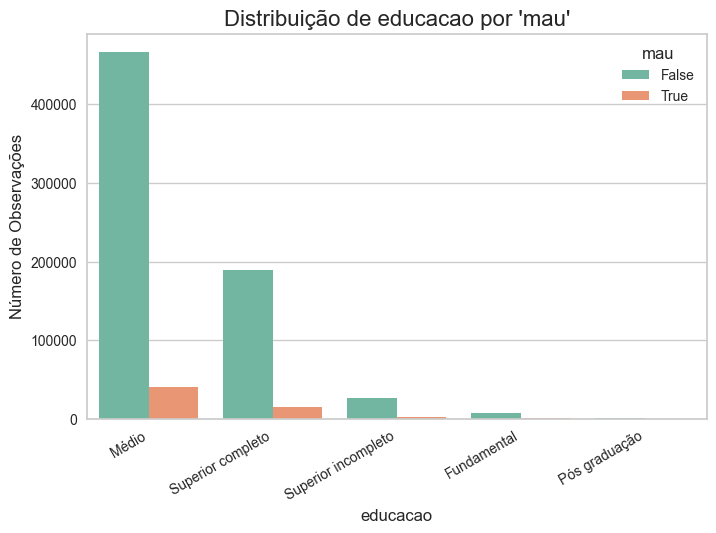

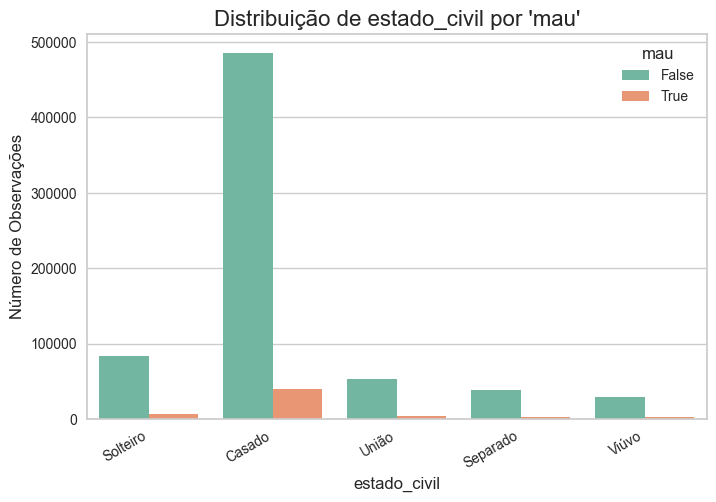

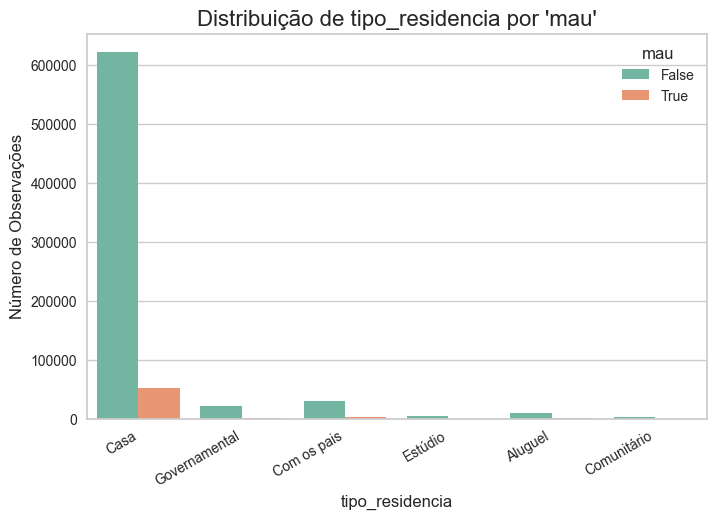

In [52]:
# Gráfico de barras para cada variável categórica em relação a 'mau'
for var in [c for c in categoricas if c != 'mau']:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=var, hue='mau', palette="Set2")
    plt.title(f"Distribuição de {var} por 'mau'", fontsize=16)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Número de Observações', fontsize=12)
    plt.xticks(rotation=30, ha='right')
    plt.show()

Podemos notar que a tendencia de ser inadimplente vem daqueles grupos onde tem valor agregado, que são pessoas que tem casa própria, que são casadas, que possuem veículo. Podendo indicar que essa inadimplencia se deve ao custos mensais que uma família pode ter e não conseguiram custear.

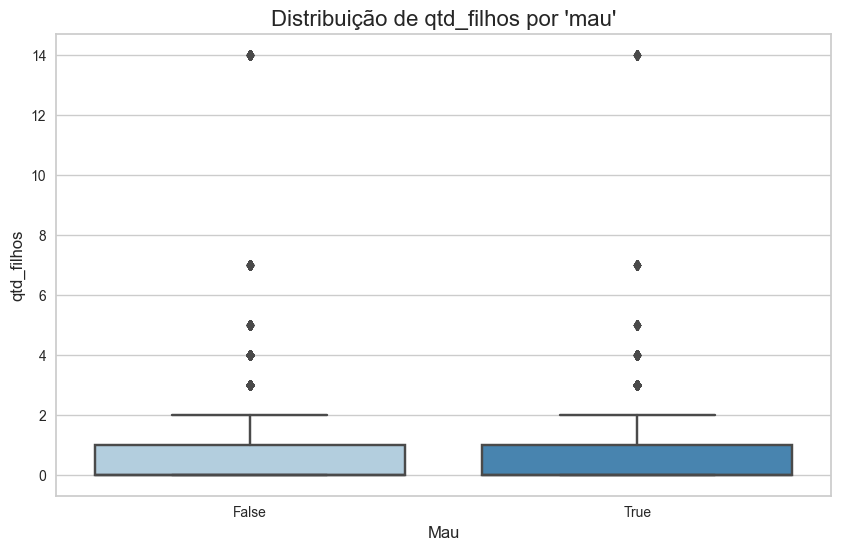

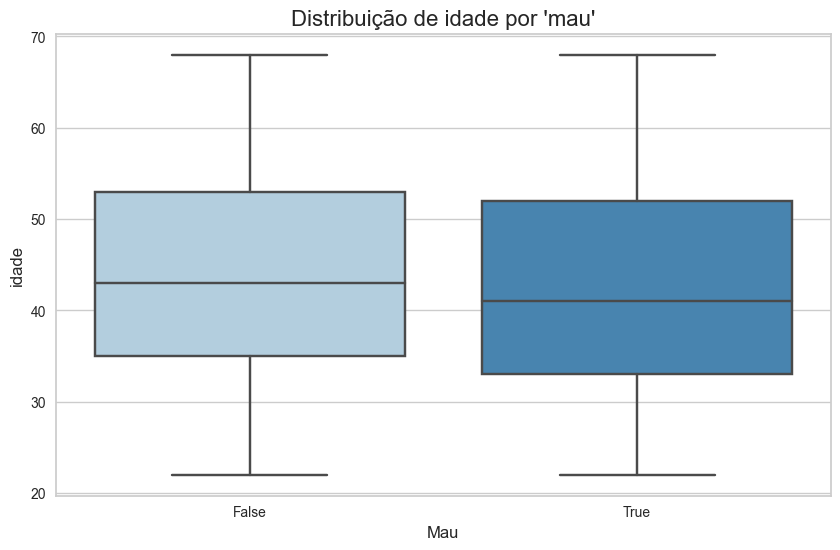

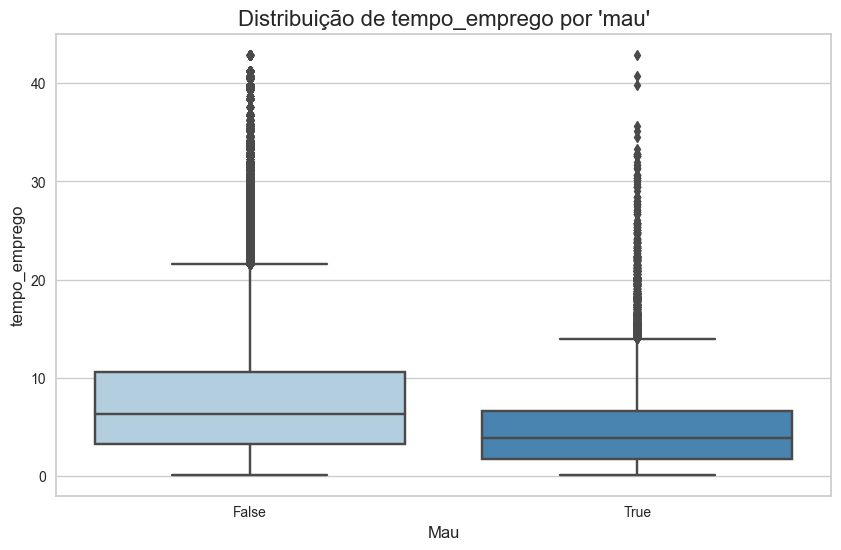

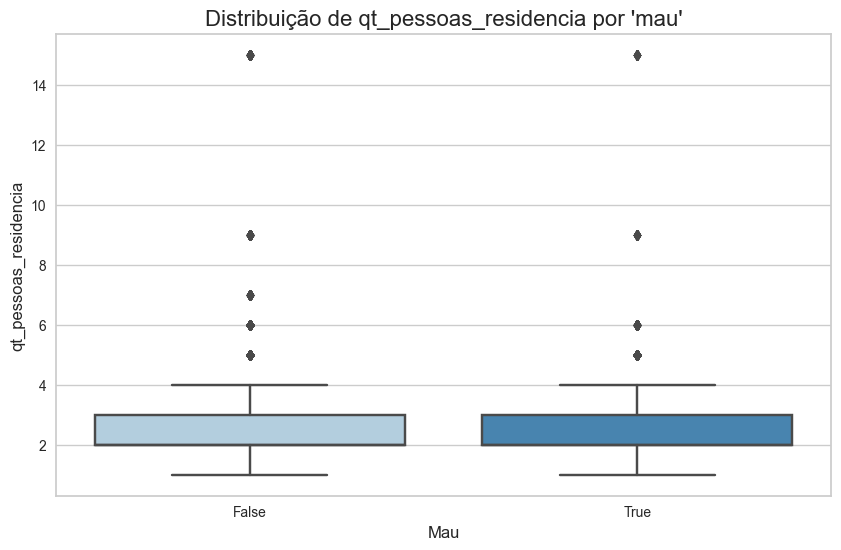

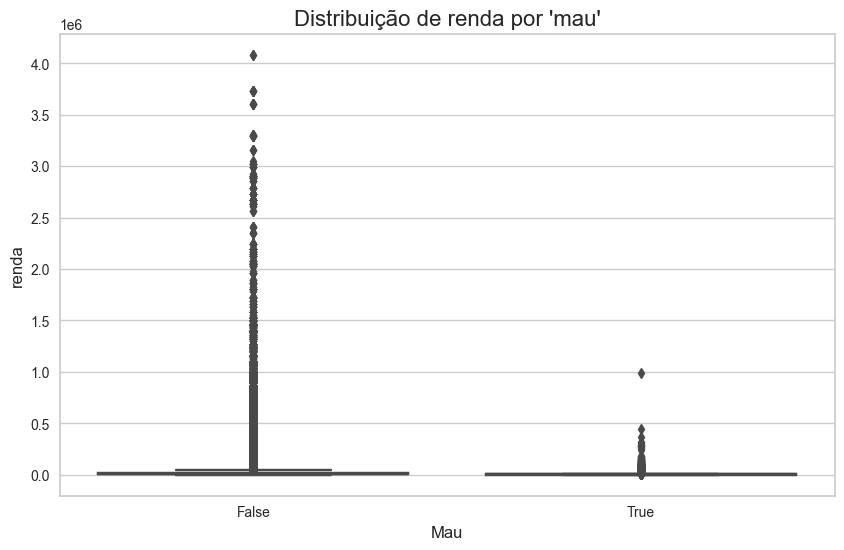

In [53]:
# Boxplot para variáveis numéricas em relação a 'mau'
for var in numericas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='mau', y=var, palette="Blues")
    plt.title(f"Distribuição de {var} por 'mau'", fontsize=16)
    plt.xlabel('Mau', fontsize=12)
    plt.ylabel(var, fontsize=12)
    plt.show()

Podemos ver por essa análise um reflexo na análise anterior, o inadimplentes são pessoas adultas, que não recebem fortunas, e principalmente, com menos tempo de emprego.

 Surpreendentemente, quantidade de filhos, aparentemente, não indica nada.

## **4.Desenvolvimento do Modelo**

### 4.1.Tratamento dos Dados

#### 4.1.1.Missings

A única variável a qual possui missing é tempo_emprego, portanto, vamos susbtituir por 0, pois significa que o cliente está desempregado no momento.

In [54]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(0)

#### 4.1.1.Tranformando as Variáveis Binárias em Inteiras

In [55]:
df['sexo'] = df['sexo'].apply(lambda x: 1 if x == 'F' else 0)

In [56]:
df['posse_de_veiculo'] = df['posse_de_veiculo'].apply(lambda x: 1 if x == 'S' else 0)

In [57]:
df['posse_de_imovel'] = df['posse_de_imovel'].apply(lambda x: 1 if x == 'S' else 0)

In [58]:
#Dividindo a base em treino e teste
df_treino = df[df['data'] < data_corte]
df_teste = df[df['data'] >= data_corte]

### 4.2.Análise do Information Value

O Information Value (IV) é uma métrica usada em estatística e aprendizado de máquina para avaliar a relação entre uma variável independente e uma variável dependente binária. É amplamente utilizado na construção de modelos de risco de crédito para medir a capacidade preditiva de variáveis explicativas. O IV baseia-se no conceito de Weight of Evidence (WoE) e calcula a separação entre as classes (ex.: bons e maus pagadores) ao dividir os dados em bins e comparar as distribuições relativas das classes em cada bin. Valores altos de IV indicam forte relação preditiva, enquanto valores muito baixos sugerem irrelevância.

In [59]:
#Função que retorna o Information Value para uma determinada variável

def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [60]:
#Panorama Geral
metadados = pd.DataFrame(data=df.drop(columns='data').dtypes, columns=['tipo'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'

metadados

,tipo,nmissing,valores_unicos,papel
sexo,int64,0,2,covariavel
posse_de_veiculo,int64,0,2,covariavel
posse_de_imovel,int64,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [61]:
#calculando o iv em %
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>8):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)*100
    else:
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)*100


metadados

,tipo,nmissing,valores_unicos,papel,IV
sexo,int64,0,2,covariavel,0.218470
posse_de_veiculo,int64,0,2,covariavel,0.010849
posse_de_imovel,int64,0,2,covariavel,0.969312
qtd_filhos,int64,0,8,covariavel,0.163055
tipo_renda,object,0,5,covariavel,0.936006
educacao,object,0,5,covariavel,0.354652
estado_civil,object,0,5,covariavel,0.112563
tipo_residencia,object,0,6,covariavel,0.304457
idade,int64,0,47,covariavel,1.796842
tempo_emprego,float64,0,3005,covariavel,26.543441


Pela a inferência do Information Value, apenas `idade`, `renda` e `tempo_emprego` tiveram um IV aceitável.

### 4.3.Análise P-value

Inicialmente, vamos fazer a regressão logística com todas as variáveis, exceto a data, e avaliar o p-value de todas.

In [62]:
formula = '''mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos +
             tipo_renda + educacao + estado_civil + tipo_residencia + idade +
             tempo_emprego + qt_pessoas_residencia + renda'''

rl1 = smf.glm(formula, data=df_treino, family=sm.families.Binomial()).fit()

rl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               550000
Model:                                     GLM   Df Residuals:                   549974
Model Family:                         Binomial   Df Model:                           25
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.1002e+05
Date:                         Wed, 18 Dec 2024   Deviance:                   2.2004e+05
Time:                                 19:59:14   Pearson chi2:                 9.69e+15
No. Iterations:                             11   Pseudo R-squ. (CS):            0.04079
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.3617      0.208      6.548      0.000       0.954       1.769
tipo_renda[T.Bolsista]              -0.1572      0.328     -0.479      0.632      -0.801       0.486
tipo_renda[T.Empresário]             0.0500      0.015      3.338      0.001       0.021       0.079
tipo_renda[T.Pensionista]            0.2233      0.024      9.409      0.000       0.177       0.270
tipo_renda[T.Servidor público]       0.0497      0.025      1.991      0.047       0.001       0.099
educacao[T.Médio]                    0.0276      0.052      0.528      0.598      -0.075       0.130
educacao[T.Pós graduação]            0.0670      0.180      0.372      0.710      -0.286       0.420
educacao[T.Superior completo]        0.0833      0.053      1.562      0.118      -0.021       0.188
educacao[T.Superior incompleto]      0.0757      0.060      1.268      0.205      -0.041       0.193
estado_civil[T.Separado]             0.0588      0.100      0.587      0.557      -0.138       0.255
estado_civil[T.Solteiro]             0.0778      0.098      0.793      0.428      -0.114       0.270
estado_civil[T.União]               -0.0577      0.022     -2.656      0.008      -0.100      -0.015
estado_civil[T.Viúvo]                0.1211      0.102      1.189      0.235      -0.079       0.321
tipo_residencia[T.Casa]              0.1204      0.047      2.578      0.010       0.029       0.212
tipo_residencia[T.Com os pais]       0.1124      0.053      2.134      0.033       0.009       0.216
tipo_residencia[T.Comunitário]       0.1636      0.095      1.726      0.084      -0.022       0.349
tipo_residencia[T.Estúdio]           0.0698      0.088      0.792      0.428      -0.103       0.242
tipo_residencia[T.Governamental]     0.1242      0.057      2.186      0.029       0.013       0.235
sexo                                -0.1169      0.014     -8.321      0.000      -0.144      -0.089
posse_de_veiculo                    -0.0326      0.013     -2.463      0.014      -0.059      -0.007
posse_de_imovel                      0.0846      0.013      6.690      0.000       0.060       0.109
qtd_filhos                          -0.0953      0.097     -0.981      0.327      -0.286       0.095
idade                               -0.0004      0.001     -0.566      0.571      -0.002       0.001
tempo_emprego                        0.0214      0.002     11.108      0.000       0.018       0.025
qt_pessoas_residencia                0.0884      0.097      0.912      0.362      -0.102       0.278
renda                             9.789e-05   1.11e-06     88.283      0.000    9.57e-05       0.000
=======================================================

As variáveis que obtiveram P-value aceitável (menor que 5%, ou suficientemente perto): `renda`, `tempo_emprego`, `posse_de_imovel`,`tipo_renda`, `posse_de_veiculo`, `sexo`.

### 4.4.Modelos de Regressão Logística

#### 4.1.Modelo de variáveis pelo o IV

In [63]:
formula_iv = '''mau ~ idade + tempo_emprego + renda'''
rl_iv = smf.glm(formula_iv, data=df_treino, family=sm.families.Binomial()).fit()

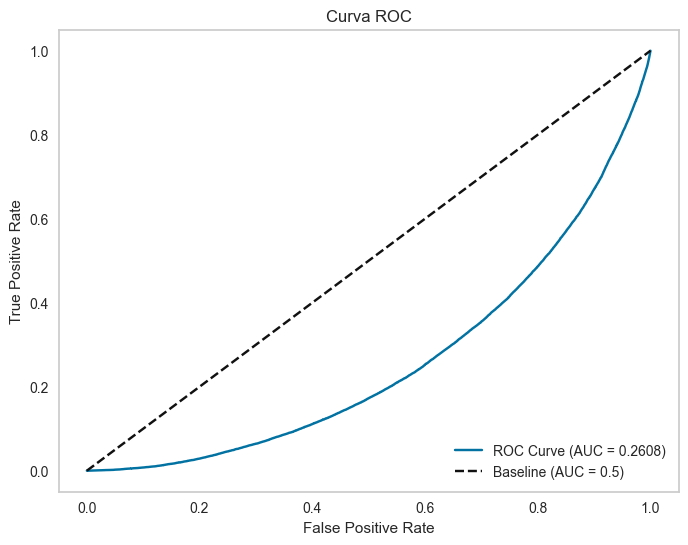

In [64]:
# Calcular as probabilidades preditas
df_teste['scoring'] = rl_iv.predict(df_teste)

# Definir um threshold para converter probabilidades em evento ou não evento
threshold = 0.5
df_teste['predicao'] = (df_teste['scoring'] >= threshold).astype(int)

# Calcula AUC-ROC
auc = roc_auc_score(df_teste['mau'], df_teste['scoring'])

# Calcula a acurácia
accuracy = accuracy_score(df_teste['mau'], df_teste['predicao'])

# Calcula a curva ROC
fpr, tpr, thresholds = roc_curve(df_teste['mau'], df_teste['scoring'])

# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Baseline (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [65]:
print(f'Acurácia do modelo: {accuracy}')
print(f'AUC do modelo: {auc}')

Acurácia do modelo: 0.13428
AUC do modelo: 0.2607758457135987


Esse modelo está bem ruim, anaalisando a Curva ROC, o modelo é pior do que um modelo aleatório (acurácia 50%).

#### 4.2.Modelo de variáveis pelo o P-Value

In [66]:
formula_pvalue = '''mau ~ sexo + tipo_renda + posse_de_veiculo + posse_de_imovel + tempo_emprego + renda'''
rl_pvalue = smf.glm(formula_pvalue, data=df_treino, family=sm.families.Binomial()).fit()

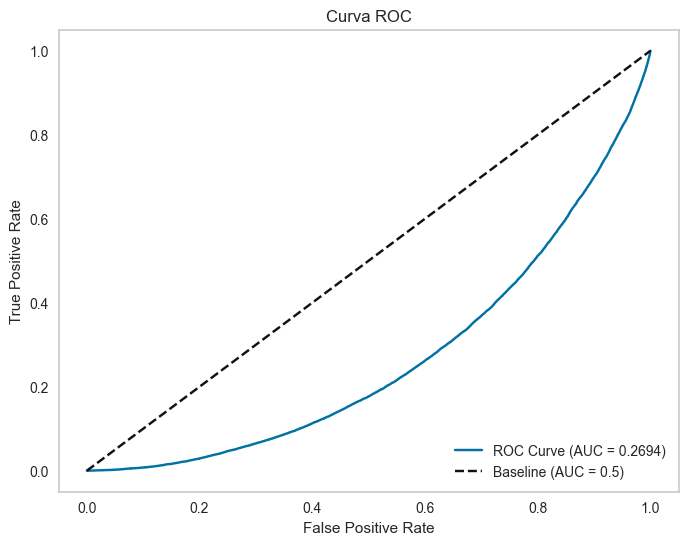

In [67]:
df_teste['scoring'] = rl_pvalue.predict(df_teste)

threshold = 0.5
df_teste['predicao'] = (df_teste['scoring'] >= threshold).astype(int)

auc = roc_auc_score(df_teste['mau'], df_teste['scoring'])


accuracy = accuracy_score(df_teste['mau'], df_teste['predicao'])


fpr, tpr, thresholds = roc_curve(df_teste['mau'], df_teste['scoring'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Baseline (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [68]:
print(f'Acurácia do modelo: {accuracy}')
print(f'AUC do modelo: {auc}')

Acurácia do modelo: 0.13428
AUC do modelo: 0.2694045541036844


Mesma coisa, um péssimo modelo.

## **5.PyCaret**

Como não obtivemos um resultado bom com Regressão Logística, então por que não treinamos outros modelos e pegamos aquele com melhor resultado.

Podemos fazer isso com o Pycaret.

### 5.1.Pipeline

Vamos criar uma pipeline que faça um pré-processamento dos dados, sendo eles:
* Substituição dos missing
* Transforma as variáveis categóricas em Dummies
* PCA para 5 componentes
* Criação de Dummies


#### 5.1.1.Funções

In [69]:
def missing (df):
    df.fillna(0, inplace=True)
    return df

In [70]:
def substituir_outliers(df, colunas=None, estrategia="mediana"):
    """
    Parâmetros:
    - df: DataFrame de entrada.
    - colunas: Lista de colunas numéricas a serem analisadas. Se None, todas as colunas numéricas serão usadas.
    - estrategia: Método de substituição dos outliers:
        - 'mediana' (padrão): Substitui por mediana da coluna.
        - 'limite': Substitui pelos limites inferior e superior do IQR.
    """
    if colunas is None:
        colunas = df.select_dtypes(include=["number"]).columns

    df_tratado = df.copy()

    for coluna in colunas:
        Q1 = df[coluna].quantile(0.25)
        Q3 = df[coluna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        if estrategia == "mediana":
            mediana = df[coluna].median()
            df_tratado[coluna] = np.where(
                (df[coluna] < limite_inferior) | (df[coluna] > limite_superior),
                mediana,
                df[coluna],
            )

        elif estrategia == "limite":
            df_tratado[coluna] = np.where(
                df[coluna] < limite_inferior, limite_inferior,
                np.where(df[coluna] > limite_superior, limite_superior, df[coluna])
            )

    return df_tratado

In [71]:
def aplicar_pca(df, n_componentes=5):
    # Selecionar apenas colunas numéricas
    colunas_numericas = df.select_dtypes(include=["number"])

    # Aplicar PCA
    pca = PCA(n_components=n_componentes, random_state=42)
    componentes_principais = pca.fit_transform(colunas_numericas)

    # Criar novo DataFrame com os componentes principais
    df_pca = pd.DataFrame(
        componentes_principais,
        columns=[f"PCA_{i+1}" for i in range(n_componentes)],
        index=df.index
    )

    return df_pca

In [72]:
def dummies(df):

    categorical_cols = df.select_dtypes(include=['object']).columns
    df_2 = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df_2

#### 5.1.2.Pipeline finalizada

In [73]:
pipeline = Pipeline([
    ('missing', FunctionTransformer(missing, validate=False)),
    ('dummies', FunctionTransformer(dummies, validate=False)),
    ('outliers', FunctionTransformer(lambda df: substituir_outliers(df, estrategia="mediana"), validate=False)),
    ('pca', FunctionTransformer(lambda df: aplicar_pca(df, n_componentes=5), validate=False))
])

Podemos utilizar essa pipeline, como também podemos utilizar a pipeline nativa do pycaret, entretando, ele é limitada em alguma coisas, como ele não substituie os missings, apenas os remove.

Aqui, vamos ver qual que se sai melhor e selecionar o melhor.

In [74]:
df_tratado = pipeline.fit_transform(df.drop(columns=['data', 'mau'], axis=1))
df_tratado = pd.concat([df_tratado, df['mau']], axis=1)

### 5.2.Setup

Antes, vamos forçar a variável qtd_filhos para float, pois o PyCret trata variáveis numéricas inteira com poucos valores únicos como categorias.

In [75]:
#Dados que utilizarão a pipeline nativa do Pycaret

data = df.drop(columns='data', axis=1).sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index).drop(columns='data', axis=1)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (712500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (37500, 13)


In [76]:
#Dados que usarão a minha pipeline
data_t = df_tratado.sample(frac=0.95, random_state=786)
data_unseen_t = df_tratado.drop(data_t.index)
data_t.reset_index(inplace=True, drop=True)
data_unseen_t.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data_t.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen_t.shape))

Conjunto de dados para modelagem (treino e teste): (712500, 6)
Conjunto de dados não usados no treino/teste, apenas como validação: (37500, 6)


### 5.3.Modelo sem pipeline

Usando o método nativo do PyCaret

In [77]:
clf_tratada = setup(data=data, 
             target='mau', 
             imputation_type='simple',  # A imputação será simples (média ou moda)
             categorical_features=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'],
             numeric_features=['idade', 'tempo_emprego', 'qtd_filhos', 'qt_pessoas_residencia'],
             normalize=True,
             transformation=True,
             remove_outliers=True,
             outliers_threshold=0.05,
             pca=True,
             pca_components=5
            )

,Description,Value
0,Session id,1535
1,Target,mau
2,Target type,Binary
3,Original data shape,"(712500, 13)"
4,Transformed data shape,"(687563, 6)"
5,Transformed train set shape,"(473812, 6)"
6,Transformed test set shape,"(213751, 6)"
7,Numeric features,4
8,Categorical features,7
9,Preprocess,True


Como se trata de um dataset desbalanceado, vamos utilizar AUC, que é a área da Curva ROC, como métrica.

In [78]:
compare_models(fold=5, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9218,0.7464,0.0026,0.4768,0.0052,0.0043,0.0293,6.2520
gbc,Gradient Boosting Classifier,0.9218,0.7296,0.0015,0.4167,0.0030,0.0024,0.0210,18.4320
ada,Ada Boost Classifier,0.9218,0.7172,0.0006,0.4880,0.0013,0.0010,0.0133,8.9420
lda,Linear Discriminant Analysis,0.9219,0.7012,0.0002,0.5867,0.0005,0.0004,0.0100,5.8920
lr,Logistic Regression,0.9218,0.6972,0.0012,0.4045,0.0024,0.0019,0.0183,6.6620
ridge,Ridge Classifier,0.9219,0.6970,0.0000,0.0000,0.0000,0.0000,0.0000,5.8760
nb,Naive Bayes,0.9219,0.6967,0.0000,0.0000,0.0000,0.0000,0.0000,6.4840
qda,Quadratic Discriminant Analysis,0.9187,0.6788,0.0144,0.2117,0.0268,0.0170,0.0357,5.9140
rf,Random Forest Classifier,0.9029,0.6569,0.1007,0.2269,0.1395,0.0961,0.1051,16.3460
knn,K Neighbors Classifier,0.9135,0.6367,0.0723,0.2874,0.1156,0.0869,0.1105,7.2140


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1535, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

Para esse setup, o melhor desempenho foi com o lightgbm, que é um modelo de árvore de decisão sequenciais que utilizam o gradiente de erro para correção do modelo anterior. É bem parecido com o Random Forest, a diferença é que o Random Forest são árvore independentes, e o lightgbm são sequenciais, onde uma árvore tenta corrigir os erros da anterior.

Dito isso, vamos fazer o tunning desse melhor modelo para melhorar ainda mais.

In [79]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9215,0.7433,0.0041,0.3333,0.0081,0.0062,0.0295
1,0.9217,0.7453,0.0023,0.3462,0.0046,0.0036,0.0228
2,0.9219,0.7535,0.0018,0.7000,0.0036,0.0032,0.0328
3,0.9218,0.7436,0.0013,0.4545,0.0026,0.0021,0.0208
4,0.9219,0.7493,0.0018,0.5833,0.0036,0.0031,0.0292
5,0.9214,0.7446,0.0033,0.2708,0.0066,0.0047,0.0223
6,0.9218,0.7491,0.0008,0.3333,0.0015,0.0012,0.0128
7,0.9220,0.7414,0.0031,0.6316,0.0061,0.0054,0.0403
8,0.9219,0.7492,0.0028,0.5238,0.0056,0.0048,0.0341


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [80]:
tuned_lightgbm = tune_model(lightgbm, optimize = 'AUC', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9219,0.7490,0.0040,0.5167,0.0079,0.0067,0.0401
1,0.9218,0.7530,0.0040,0.4306,0.0079,0.0065,0.0353
2,0.9218,0.7504,0.0031,0.4706,0.0061,0.0051,0.0331
3,0.9219,0.7498,0.0021,0.6154,0.0041,0.0036,0.0323
4,0.9220,0.7517,0.0031,0.6667,0.0061,0.0054,0.0417
Mean,0.9219,0.7508,0.0032,0.5400,0.0064,0.0055,0.0365
Std,0.0001,0.0014,0.0007,0.0884,0.0014,0.0011,0.0037


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Teve um singelo aumento no AUC e na acurácia, iremos salvar o melhor modelo.

In [81]:
final_model_no_pipe = finalize_model(tuned_lightgbm)

Agora vamos fazer o mesmo para a base que usamos a pipeline.

In [82]:
clf_pipe = setup(data=data_t, target = 'mau', session_id=42)

,Description,Value
0,Session id,42
1,Target,mau
2,Target type,Binary
3,Original data shape,"(712500, 6)"
4,Transformed data shape,"(712500, 6)"
5,Transformed train set shape,"(498749, 6)"
6,Transformed test set shape,"(213751, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [83]:
compare_models(fold=5, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9223,0.7818,0.0251,0.5565,0.0481,0.0416,0.1061,12.6960
lightgbm,Light Gradient Boosting Machine,0.9222,0.7808,0.0241,0.5502,0.0462,0.0399,0.1031,0.5020
ada,Ada Boost Classifier,0.9223,0.7807,0.0281,0.5516,0.0534,0.0461,0.1111,3.1620
svm,SVM - Linear Kernel,0.8897,0.7690,0.2547,0.2444,0.2259,0.1786,0.1890,3.6680
lr,Logistic Regression,0.9219,0.7664,0.0000,0.0000,0.0000,0.0000,0.0000,0.4900
ridge,Ridge Classifier,0.9219,0.7515,0.0000,0.0000,0.0000,0.0000,0.0000,0.1020
lda,Linear Discriminant Analysis,0.9219,0.7515,0.0000,0.0000,0.0000,0.0000,0.0000,0.1120
nb,Naive Bayes,0.9219,0.7342,0.0000,0.0000,0.0000,0.0000,0.0000,0.1060
qda,Quadratic Discriminant Analysis,0.9219,0.7309,0.0000,0.0000,0.0000,0.0000,0.0000,0.1340
rf,Random Forest Classifier,0.9023,0.6682,0.1043,0.2276,0.1431,0.0988,0.1073,13.7280


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Para esse caso, o melhor modelo foi o Gradient Boosting Classifier, que é um algoritmo de aprendizado supervisionado baseado na técnica de boosting, onde modelos fracos (geralmente árvores de decisão) são treinados sequencialmente, com cada novo modelo corrigindo os erros dos modelos anteriores. O GBC ajusta iterativamente os pesos das instâncias mal classificadas para melhorar a precisão geral, combinando as predições de todas as árvores treinadas.

Esse correção de erro por gradiente é o mesmo que algoritmo de redes neurais usam, como o MLP.

In [84]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9218,0.7749,0.0228,0.4917,0.0436,0.0370,0.0930
1,0.9219,0.7825,0.0205,0.5096,0.0395,0.0336,0.0903
2,0.9225,0.7814,0.0241,0.6104,0.0464,0.0407,0.1104
3,0.9218,0.7821,0.0259,0.4903,0.0492,0.0417,0.0989
4,0.9223,0.7808,0.0226,0.5677,0.0434,0.0377,0.1019
5,0.9221,0.7809,0.0234,0.5291,0.0447,0.0384,0.0988
6,0.9225,0.7842,0.0257,0.5882,0.0492,0.0429,0.1112
7,0.9220,0.7783,0.0218,0.5280,0.0419,0.0359,0.0954
8,0.9229,0.7857,0.0318,0.6294,0.0606,0.0535,0.1294


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [85]:
tuned_gbc = tune_model(gbc, optimize = 'AUC', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9218,0.7783,0.0242,0.4884,0.0462,0.0391,0.0954
1,0.9220,0.7810,0.0260,0.5219,0.0496,0.0425,0.1034
2,0.9221,0.7805,0.0227,0.5284,0.0435,0.0373,0.0974
3,0.9221,0.7802,0.0231,0.5310,0.0443,0.0380,0.0985
4,0.9224,0.7856,0.0273,0.5710,0.0522,0.0453,0.1125
Mean,0.9221,0.7811,0.0247,0.5281,0.0472,0.0405,0.1015
Std,0.0002,0.0024,0.0018,0.0263,0.0033,0.0030,0.0061


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## 6.**Resultados**

O melhor modelo utilizando a pipeline nativa do pycaret teve: $92,19%$ de acurácia e $75,19$ de AUC, enquanto o melhor modelo utilizando a nossa pipeline teve $92,21%$ de acurácia e $78,11%$ de AUC, sendo bem melhor. O que indica que nosso pré-processamento fez com que o modelo previsse bem menos falsos negativos.

Vamos salvar esse modelo para a nossa aplicação no streamlit.

In [86]:
final_model = finalize_model(tuned_gbc)

In [87]:
save_model(final_model,'Final GBC Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4',
                                              'PCA_5'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, include=[],...
                                             criterion='friedman_mse', init=None,
                                             lear

### 6.1.Avaliando a base não vista

No caso, iremos carregar o modelo que salvamos, e dar um predict na base não vista o qual aplicamos a nossa pipelina, `data_unseen_t`.

In [94]:
#Carregar o modelo o qual salvamos
final_gbc_model = load_model('Final GBC Model')

Transformation Pipeline and Model Successfully Loaded


In [95]:
# Separando features e target no dataset
X_unseen = data_unseen_t.drop(columns=['mau'])
y_unseen = data_unseen_t['mau']

# Fazendo as previsões de probabilidade e classe
y_scores = final_gbc_model.predict_proba(X_unseen)[:, 1] 
y_pred = final_gbc_model.predict(X_unseen)

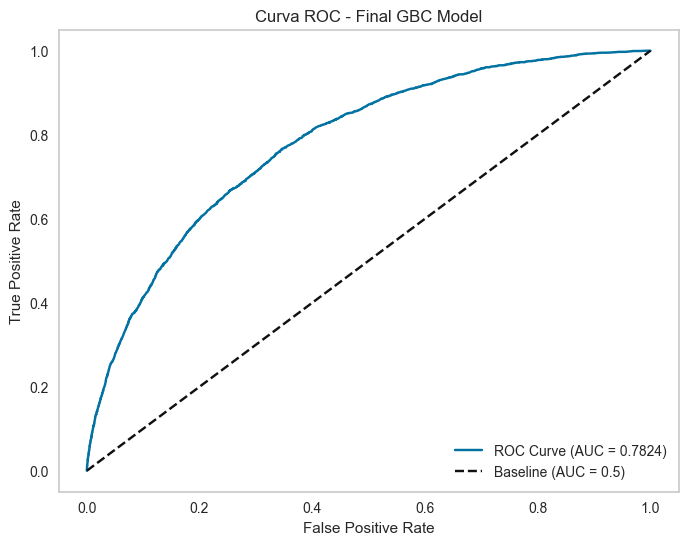

Acurácia: 0.9213
AUC: 0.7824


In [96]:
#Métricas
# Calcular métricas de desempenho
accuracy = accuracy_score(y_unseen, y_pred)
auc = roc_auc_score(y_unseen, y_scores)

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_unseen, y_scores)

# Plot da curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Baseline (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Final GBC Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Exibir resultados
print(f"Acurácia: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")

Obtivemos resultados similares com as métricas da base de treino, isso significa que o nosso modelo está sólido.

## **6.Streamlit**

Com isso, todo o "esqueleto" está pronto. Basta agora, aplicar a pipeline que desenvolvemos, e o modelo que salvamos, para que tenhas nossos resultados de predição se o cliente é bom ou ruim. Para isso, vamos utilizar o mesmo dataframe o qual utilizamos, mas desta vez sem nenhum tratamento e sem a variável target presente, simulando a inserção de novos clientes na base de dados.

In [98]:
#Trazendo a mesma base
df = pd.read_feather('credit_scoring.ftr').sort_values('data_ref').drop(columns=['index', 'data_ref']).reset_index()
#Salvando em csv
df.to_csv('dados_insercao_streamlit.csv', index=False)


Portanto, é esse arquivo que deve ser upado no streamlit.